## 建立csv檔用來儲存地址名稱

In [1]:
import csv
data = [
    ['address'],
    ['成功大學']
]
with open('addresses.csv', mode='w', newline='',  encoding='big5') as file:
    writer = csv.writer(file)
    writer.writerows(data)
    

透過nominatim網站存地址的經緯度

In [44]:
import requests
import pandas as pd
import time

def get_lat_long (address):
    url = "https://nominatim.openstreetmap.org/search"
    params = {
        "q": address,# 要搜索的地址
        "format": "json",# 返回數據的格式
        "limit": 1# 返回的搜索結果數量
    }
    response = requests.get(url, params=params)
    data = response.json()

    if data:
        location = data[0]
        return location["lat"], location["lon"]
    else:
        return None, None

# 讀取地址文件
addresses = pd.read_csv('addresses.csv', encoding='big5')

# 創建經緯度儲存結果
latitudes = []
longitudes = []

# 依序取得地址
for address in addresses['address']:
    lat, lng = get_lat_long(address)
    latitudes.append(lat)
    longitudes.append(lng)
    time.sleep(0.1)  # 延遲 0.1 秒
    
addresses['latitude'] = latitudes
addresses['longitude'] = longitudes

# 將結果保存到新的 CSV 文件中，指定編碼方式
addresses.to_csv('addresses_with_latlong.csv', index=False, encoding='utf-8')

print("經緯度已保存")


經緯度已保存


### 路徑最佳化

最佳路徑順序:
('成功大學', 23.0011082, 120.21817)
('南紡購物中心', 22.9911067, 120.23303814271932)
('臺南市臺南文化中心', 22.9745075, 120.221554)
('國立臺灣歷史博物館', 23.0583507, 120.2351543932651)


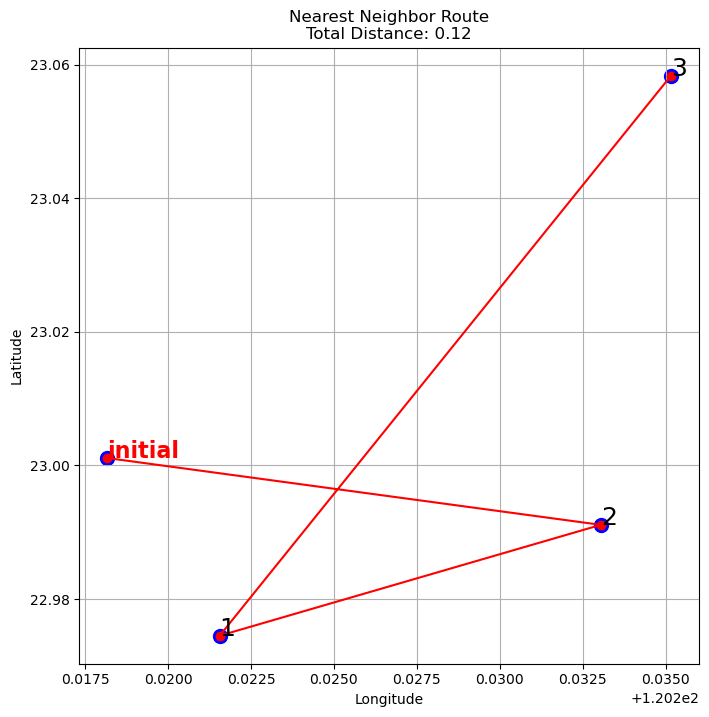

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 讀取地址資料
addresses = pd.read_csv('addresses_with_latlong.csv')
locations = addresses[['latitude', 'longitude']].values
addr = addresses['address'].tolist()

# 計算距離矩陣
def distance_matrix(locations):
    num_locations = len(locations)
    dist_matrix = np.zeros((num_locations, num_locations))
    for i in range(num_locations):
        for j in range(num_locations):
            dist_matrix[i, j] = np.linalg.norm(locations[i] - locations[j])
    return dist_matrix
    
dist_matrix = distance_matrix(locations)
# 最近鄰算法
def nearest_neighbor(dist_matrix):
    num_locations = len(dist_matrix)
    visited = [False] * num_locations
    route = [0]  # 從成功大學開始
    visited[0] = True
    total_distance = 0

    for _ in range(num_locations - 1):
        current_location = route[-1]
        nearest_dist = float('inf')
        nearest_location = None
        for j in range(num_locations):
            if not visited[j] and dist_matrix[current_location, j] < nearest_dist:
                nearest_dist = dist_matrix[current_location, j]
                nearest_location = j
        if nearest_location is not None:
            route.append(nearest_location)
            visited[nearest_location] = True
            total_distance += nearest_dist
        else:
            break

    return route, total_distance

route, total_distance = nearest_neighbor(dist_matrix)

# 將最佳路徑轉換為指定格式的列表
path_order = [(addr[i], locations[i, 0], locations[i, 1]) for i in route]

# 印出最佳路徑列表
print("最佳路徑順序:")
for location in path_order:
    print(location)


# visualize
plt.figure(figsize=(8, 8))
plt.scatter(locations[:, 1], locations[:, 0], color='blue', s=100) 
for i, (lat, lon) in enumerate(locations):
    if i==0:
        plt.text(lon, lat, f'initial', fontsize=16, color='red', weight='bold')
    else:
        plt.text(lon, lat, str(i), fontsize=18)
    
route_locations = locations[route]
plt.plot(route_locations[:, 1], route_locations[:, 0], color='red', marker='o')  # 注意經緯度的順序
plt.title(f'Nearest Neighbor Route\nTotal Distance: {total_distance:.2f}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()


### 開啟googlemap

In [46]:
path_order

[('成功大學', 23.0011082, 120.21817),
 ('南紡購物中心', 22.9911067, 120.23303814271932),
 ('臺南市臺南文化中心', 22.9745075, 120.221554),
 ('國立臺灣歷史博物館', 23.0583507, 120.2351543932651)]

In [47]:
import webbrowser
google_maps_url = "https://www.google.com/maps/dir/"
for address, lat, lon in path_order:
    google_maps_url += "/" + address
webbrowser.open(google_maps_url)


True

### 建立gui加入地址後執行

In [ ]:
import tkinter as tk
from tkinter import messagebox
import csv
import subprocess

def add_address():
    address = addr_entry.get()
    if address:
        data.append([address])
        address_list.insert(tk.END, address)
        addr_entry.delete(0, tk.END)
    else:
        messagebox.showwarning("Warning", "Please enter an address.")

def save_to_csv():
    with open('addresses.csv', mode='w', newline='', encoding='big5') as file:
        writer = csv.writer(file)
        writer.writerows(data)
    messagebox.showinfo("Success", "Addresses saved to CSV.")

def execution():
    # 執行另一個Python檔案
    try:
        subprocess.run(["python", "final.py"], check=True)
        messagebox.showinfo("Success", "Script executed successfully.")
    except subprocess.CalledProcessError as e:
        messagebox.showerror("Error", f"An error occurred: {e}")

# GUI
root = tk.Tk()
root.title("Address Manager")

addr_entry = tk.Entry(root, width=40)
addr_entry.pack(pady=10)

add_button = tk.Button(root, text="Add Address", command=add_address)
add_button.pack(padx=10, pady=5)

address_list = tk.Listbox(root, height=10, width=50)
address_list.pack()

save_button = tk.Button(root, text="Save to CSV", command=save_to_csv)
save_button.pack(pady=5)

execution_button = tk.Button(root, text="Execution", command=execution)
execution_button.pack(pady=5)

root.mainloop()
